# Data preparation
Outlines the steps taken to prepare the data for use in data modelling


Ensure that you run this to allow access to your drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

#to ensure that this code runs, please upload the temperature and total demand csv that can be found within this directory onto your google drive. Then upload this notebook to google collabs and as long as the authentication 
#is established between your drive and account it will run

Read in the supplied datasets, one for Temperature the other for total energy demand. The two datasets that were used to build and report on the data models in this project were sourced from Course material (ZZSC9020). The data was collected over a period of 10+years from Jan 1, 2010 through to Mar 18, 2021. We have assumed that the REGIONID, NSW1, corresponds to the geospatial location intersected by BANKSTOWN AERODOME weather station where the temperature data was collected from. However this HAS NOT been confirmed.

In [ ]:
# import required libraries
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. Read the Temperature CSV file into a DataFrame
df = pd.read_csv("/content/drive/MyDrive/temperature_nsw.csv")

# 2. Convert the 'DATETIME' column in TEMP dataset to datetime format
df['DATETIME'] = pd.to_datetime(df['DATETIME'], format='%d/%m/%Y %H:%M')

# 3. Extract the hour and minute from the 'datetime' column
df['HOUR'] = df['DATETIME'].dt.hour
df['MINUTE'] = df['DATETIME'].dt.minute

# 4. Remove rows where 'MINUTE' is not 0 or 30
df = df[df['MINUTE'].isin([0, 30])]

# 5. Read the energy demand CSV file into a DataFrame
df_energy = pd.read_csv('/content/drive/MyDrive/totaldemand_nsw.csv')

# 6. Convert the 'DATETIME' column to datetime format for the energy dataset
df_energy['DATETIME'] = pd.to_datetime(df_energy['DATETIME'], format='%d/%m/%Y %H:%M')

# 7. Merge the two DataFrames on 'DATETIME'
df_merged = pd.merge(df, df_energy, on='DATETIME', how='inner')

# 8. Extract the day, month, and year from the 'datetime' column and add as variables
df_merged['DAY'] = df_merged['DATETIME'].dt.day
df_merged['MONTH'] = df_merged['DATETIME'].dt.month
df_merged['YEAR'] = df_merged['DATETIME'].dt.year

# 9. Update the name of the df to ShortTerm, use copy method so that we can manipulate df_merged for the medium-term modelling dataset
df_ShortTerm = df_merged.copy()

# 10. Add a new field called 'count' and populate each row with 1
df_ShortTerm['count'] = 1

# 11. Group by the 'DAY', 'MONTH', 'YEAR', and 'HOUR' fields
grouped_df = df_ShortTerm.groupby(['DAY', 'MONTH', 'YEAR','HOUR']).agg({
    'TEMPERATURE': 'mean',  # Average the 'temp' field
    'TOTALDEMAND': 'sum',  # Sum the 'energy_demand' field
    'count': 'sum'  # Sum the 'count' field
}).reset_index()

# 12. Remove any rows where both the hourly and 1/2hourly is unavailable. Ie Drop all rows where 'count' is less than 2
df_ShortTerm = grouped_df[grouped_df['count'] >= 2]

# 13. drop the COUNT field
df_ShortTerm = df_ShortTerm.drop(['count'], axis=1)

# 14. rebuild date field
df_ShortTerm['DATE'] = pd.to_datetime(dict(year=df_ShortTerm['YEAR'], month=df_ShortTerm['MONTH'], day=df_ShortTerm['DAY']))

# 15. Add weekday number and week number to the variables then drop date (redundant field)
df_ShortTerm['WEEKDAY_Num'] = df_ShortTerm['DATE'].dt.weekday + 1  # Monday=1, Sunday=7
df_ShortTerm['WEEK_Num'] = df_ShortTerm['DATE'].dt.isocalendar().week
df_ShortTerm = df_ShortTerm.drop(['DATE'], axis=1)

print(df_ShortTerm)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/temperature_nsw.csv'

---
This will generate a Medium Term Modelling (MTM) dataset based on daily predictions. At the time of creation users have access to 3months ahead daily temperature forecasts and therefore could use the MTMs generated by this project to predict total energy demand with up to 3months lead time. It is expected that temperature forecasting will improve over time, and that this lead time will also improve.

In [ ]:
# 1. Create a Medium term modelling dataset, extract min and max temps and SUM the energy demand per date, return one row per date. Add WEEKDAY_Num, WEEK_Num, DAY, MONTH, YEAR
df_MedTerm = df_merged.groupby(df_merged['DATETIME'].dt.date).agg({'TEMPERATURE': ['min', 'max'], 'TOTALDEMAND': 'sum'}).reset_index()

# 2. Rename the created columns for clarity
df_MedTerm.columns = ['DATE', 'MinTemp', 'MaxTemp', 'TOTALDEMAND']
df_MedTerm['DATE'] = pd.to_datetime(df_MedTerm['DATE'])

# 3. Extract the weekday, week number, day, month, and year from the 'DATE' column and add as variables, then drop DATE as it is redundant
df_MedTerm['WEEKDAY_Num'] = df_MedTerm['DATE'].dt.weekday + 1  # Monday=1, Sunday=7
df_MedTerm['WEEK_Num'] = df_MedTerm['DATE'].dt.isocalendar().week
df_MedTerm['DAY'] = df_MedTerm['DATE'].dt.day
df_MedTerm['MONTH'] = df_MedTerm['DATE'].dt.month
df_MedTerm['YEAR'] = df_MedTerm['DATE'].dt.year
df_MedTerm = df_MedTerm.drop(['DATE'], axis=1)
print(df_MedTerm)

      MinTemp  MaxTemp  TOTALDEMAND  WEEKDAY_Num  WEEK_Num  DAY  MONTH  YEAR
0        22.1     28.8    374464.94            5        53    1      1  2010
1        22.2     29.4    384838.07            6        53    2      1  2010
2        17.9     21.5    355195.18            7        53    3      1  2010
3        17.9     23.9    395602.57            1         1    4      1  2010
4        15.4     27.7    423735.03            2         1    5      1  2010
...       ...      ...          ...          ...       ...  ...    ...   ...
4087     14.6     24.4    340444.05            7        10   14      3  2021
4088     11.7     21.5    332669.89            1        11   15      3  2021
4089     14.2     21.3    351858.01            2        11   16      3  2021
4090     16.1     22.6    356553.02            3        11   17      3  2021
4091     18.6     18.6      7094.51            4        11   18      3  2021

[4092 rows x 8 columns]


---
#Creating Train:Test datasets
To ensure that the varaitions in accuracy from each model tested are reflecting the models performance and not the underlying data, a consistent Training and Testing dataset is created for both the Short Term modelling (Hourly) and Medium Term Modelling (Daily) data.

In [ ]:
# 1. Set 'X' (data) and 'y' (label) for ShortTimeModelling (STM)
X_STM = df_ShortTerm.drop(['TOTALDEMAND'], axis=1)
y_STM = df_ShortTerm['TOTALDEMAND']

# 2. Create Test:Train STM dataset using 80:20 split and random state set at 51
X_STMtrain, X_STMtest, y_STMtrain, y_STMtest = train_test_split(X_STM, y_STM, test_size=0.2, random_state=51)
print(X_STMtrain)
print(y_STMtrain)

# 3. Repeat for the MediumTimeModelling (MTM):
# Set 'X' (data) and 'y' (label) for MediumTimeModelling (MTM)
X_MTM = df_MedTerm.drop(['TOTALDEMAND'], axis=1)
y_MTM = df_MedTerm['TOTALDEMAND']

# 4. Create Test:Train MTM dataset using 80:20 split and random state set at 51
X_MTMtrain, X_MTMtest, y_MTMtrain, y_MTMtest = train_test_split(X_MTM, y_MTM, test_size=0.2, random_state=51)
print(X_MTMtrain)
print(y_MTMtrain)


       DAY  MONTH  YEAR  HOUR  TEMPERATURE  WEEKDAY_Num  WEEK_Num
4052     2      3  2019    21        22.65            6         9
40593   13      7  2013    20         8.75            6        28
77206   24     12  2012    10        31.00            1        52
61902   20      2  2020     8        21.10            4         8
95427   30     10  2010    18        20.45            6        43
...    ...    ...   ...   ...          ...          ...       ...
18159    6      8  2011    23        14.55            6        31
49198   16      3  2012    21        24.25            5        11
67445   21     11  2018    10        26.55            3        47
16907    6      3  2015    19        19.80            5        10
48223   15     11  2018     6        18.90            4        46

[78288 rows x 7 columns]
4052     16101.24
40593    18603.32
77206    18967.84
61902    15612.20
95427    16536.91
           ...   
18159    16490.18
49198    17275.97
67445    16727.50
16907    16810.54
48

#KOSH - Since the ARIMA/SAMIRA models were large please reference the 

#EMMA - Insert Polynomial Regressions here

Polynomial regression:
*   feature selection
*   degree selection
*   build model and report stats (R2, RMSE, MAE, MSE, MAPE)

repeat for Medium Term data

In [ ]:
# Import relevent libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

Short Term Model - HOURLY
---
Polynomial models require user to select required/relevent features (idependant variables) to use when predicting the dependant variable, along with the degree (complexity) of the polynomial to use.


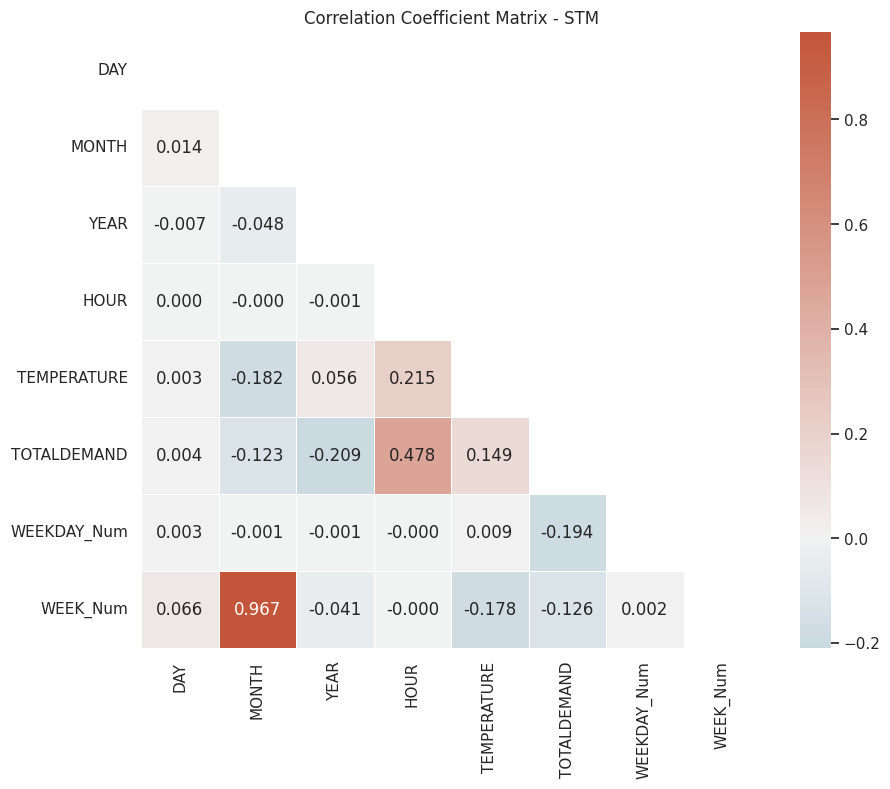

In [ ]:
# For the STM data
# 1.0 Compute the correlation matrix
STMcorr_matrix = df_ShortTerm.corr()

# 2.0 Visualise the correlation matrices using Seaborn
sns.set_theme(style="white")
mask = np.triu(np.ones_like(STMcorr_matrix, dtype=bool))

plt.figure(figsize=(10, 8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(STMcorr_matrix, mask=mask, cmap=cmap, center=0, annot=True, fmt="0.3f", linewidths=0.5)
plt.title("Correlation Coefficient Matrix - STM")
plt.show()



From the Correlation matrix generated, it is observed that the TOTAL DEMAND is correlated highest with HOUR, followed by YEAR, TEMPERATURE and WEEKDAY NUMBER. The other variables are very loosely correlated, and may not be of any use in the POLYNOMIAL REGRESSION Model generated.

There is also a high degree of co-linearity between MONTH and WEEK NUMBER, which means it could be redundant to keep both variables within the final models feature list.

---
Determine the highest correlating features by ranking correlation coefficent using Spearman Rank correlation to help inform which features to keep.



In [ ]:
# 1.0 Calculate Spearman rank correlation for each feature
dependent_var = "TOTALDEMAND"
correlations = {}

for feature in df_ShortTerm.columns:
    if feature != dependent_var:
        rho, _ = spearmanr(df_ShortTerm[feature], df_ShortTerm[dependent_var])
        correlations[feature] = rho

# 2.0 Sort correlations in descending order
sorted_correlations = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)

# 3.0 Print results
print("Spearman Rank Correlation outcomes - Short Term Model")
for feature, rho in sorted_correlations:
    print(f"{feature}: {rho:.4f}")

Spearman Rank Correlation outcomes - Short Term Model
HOUR: 0.4968
YEAR: -0.2168
WEEKDAY_Num: -0.1971
TEMPERATURE: 0.1183
WEEK_Num: -0.1147
MONTH: -0.1118
DAY: 0.0018


From the Spearmans rank, it is observed that Week_num is marginally higher than MONTH in correlcation with the dependent variable 'TOTALDEMAND'; therefore we will drop DAY and MONTH Variables from the Input data for the STM Forecasting model

---
determine degree of polynomial to apply;
as the data (Temp Vs TOTAL DEMAND) is non-linear (need to provide plot above for this) a POLYNOMIAL Model is requred. The 'degree' of the polynomial determines the highest power of the predictor variables in the model. The higher the degree, the more flexible the model can become, and can fit non-linear relationships better. However, there is risk of overfitting when the degree of the polynomial is too high, therefore we need to ensure appropriate degree is selected for this model.


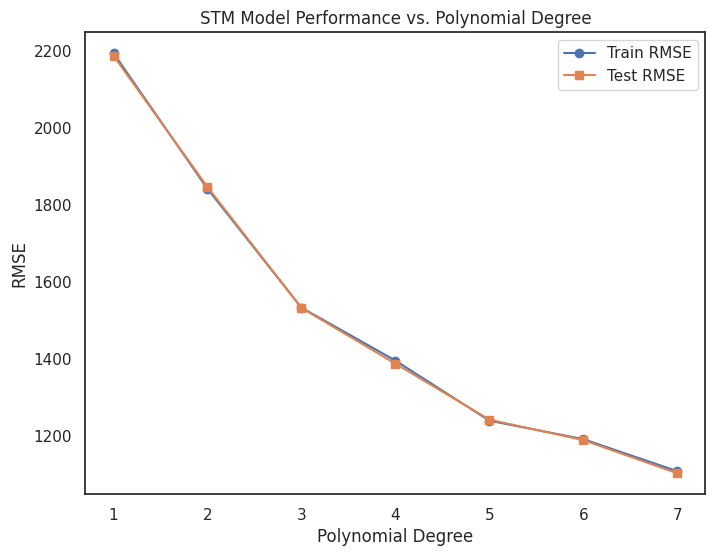

In [ ]:
# import required libraries
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# set data - drop the irrelevent features from the STM Dataset
X_train = X_STMtrain.drop(['YEAR', 'MONTH', 'DAY'], axis=1)
X_test = X_STMtest.drop(['YEAR', 'MONTH', 'DAY'], axis=1)
y_train = y_STMtrain
y_test = y_STMtest

# Try different polynomial degrees
degrees = [1, 2, 3, 4, 5, 6, 7]
train_errors, test_errors = [], []

for degree in degrees:
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    y_pred_train = model.predict(X_train_poly)
    y_pred_test = model.predict(X_test_poly)

    train_errors.append(np.sqrt(mean_squared_error(y_train, y_pred_train)))
    test_errors.append(np.sqrt(mean_squared_error(y_test, y_pred_test)))

# Plot RMSE for different degrees
plt.figure(figsize=(8, 6))
plt.plot(degrees, train_errors, label='Train RMSE', marker='o')
plt.plot(degrees, test_errors, label='Test RMSE', marker='s')
plt.xlabel('Polynomial Degree')
plt.ylabel('RMSE')
plt.title('STM Model Performance vs. Polynomial Degree')
plt.xticks(np.arange(1, 8, step=1))
plt.legend()
plt.grid(False)
plt.show()

lowest RMSE where Test performance is on par with the TRAIN data is ***Degree = 5***. The testing RMSE is better for both degree = 1, 4 and 6, indicating the model is underfitting the data and has not captured the underlying patterns sufficiently with those models. The RMSE increases with degrees 6 and 7, indicating that aditional complexity, does not result in improved predictions.

---
report the required accuracy stats for polynomial with degree of 5


In [ ]:
# import required libraries
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

# Create polynomial features
STMpoly = PolynomialFeatures(degree=5) # you can change the degree value here if needed
X_train_STMpoly = STMpoly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Fit a linear regression model
STMmodel = LinearRegression()
STMmodel.fit(X_train_poly, y_train)

# Generate predictions
y_pred_test = STMmodel.predict(X_test_poly)

# Calculate evaluation metrics
mape = mean_absolute_percentage_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print("Statiscial Measures for STM Polynimial Regression Model with Degree of 5")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:0.1f}%")
print(f"Mean Square Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Coefficient of Determination (R2): {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")



Statiscial Measures for STM Polynimial Regression Model with Degree of 5
Mean Absolute Percentage Error (MAPE): 4.8%
Mean Square Error (MSE): 1027566.24
Mean Absolute Error (MAE): 771.30
Coefficient of Determination (R2): 0.8474
Root Mean Squared Error (RMSE): 1013.6894


Medium Term (DAILY) forecasting model creation.
need to check for feature selections -


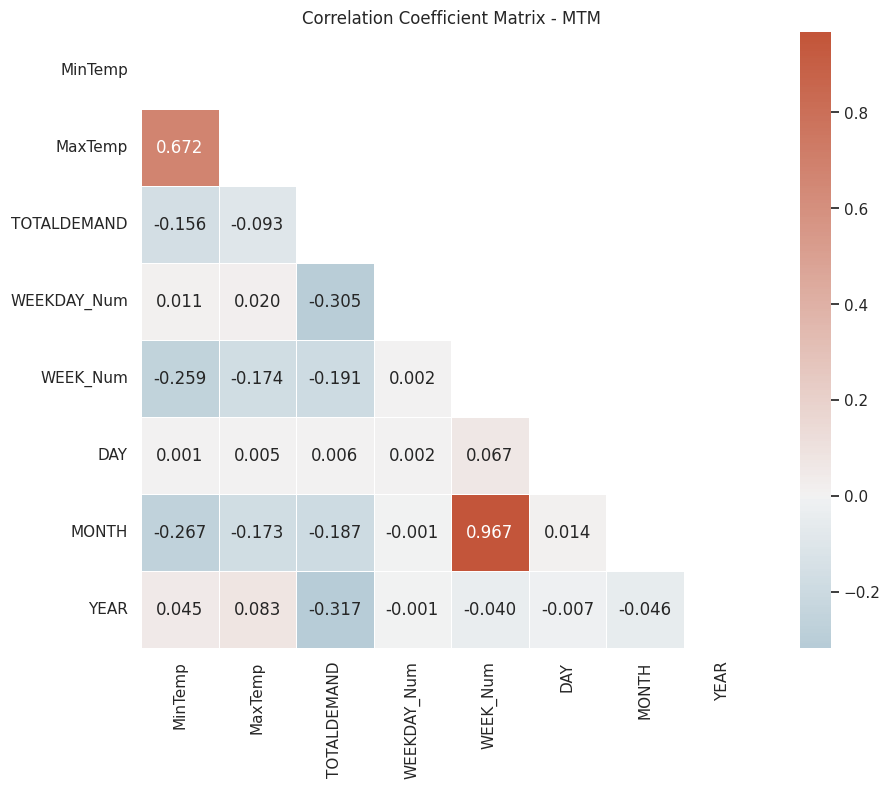

Spearman Rank Correlation outcomes - Medium Term Model
YEAR: -0.3172
WEEKDAY_Num: -0.3136
MaxTemp: -0.1970
WEEK_Num: -0.1880
MONTH: -0.1854
MinTemp: -0.1653
DAY: 0.0110


In [ ]:
from scipy.stats import spearmanr, pearsonr

# For the MTM data
# 1.0 Compute the correlation matrix
MTMcorr_matrix = df_MedTerm.corr()

# 2.0 Visualise the correlation matrices using Seaborn
sns.set_theme(style="white")
mask = np.triu(np.ones_like(MTMcorr_matrix, dtype=bool))

plt.figure(figsize=(10, 8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(MTMcorr_matrix, mask=mask, cmap=cmap, center=0, annot=True, fmt="0.3f", linewidths=0.5)
plt.title("Correlation Coefficient Matrix - MTM")
plt.show()

# 3.0 Calculate Spearman rank correlation for each feature
dependent_var = "TOTALDEMAND"
Scorrelations = {}

for feature in df_MedTerm.columns:
    if feature != dependent_var:
        rho, _ = spearmanr(df_MedTerm[feature], df_MedTerm[dependent_var])
        Scorrelations[feature] = rho

# 4.0 Sort correlations in descending order
sorted_Scorrelations = sorted(Scorrelations.items(), key=lambda x: abs(x[1]), reverse=True)

# 5.0 Print results
print("Spearman Rank Correlation outcomes - Medium Term Model")
for feature, rho in sorted_Scorrelations:
    print(f"{feature}: {rho:.4f}")


Drop DAY and MONTH from feature set


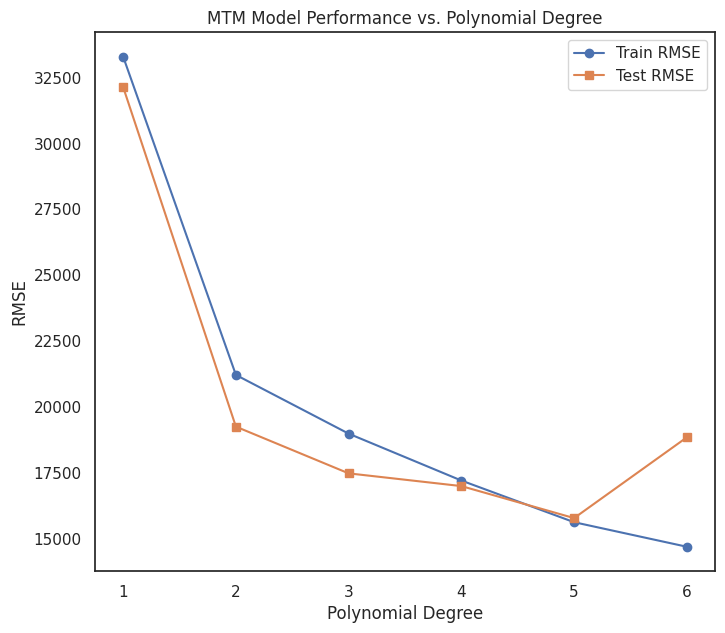

In [ ]:
# import required libraries
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# set data
X_train = X_MTMtrain.drop(['DAY', 'MONTH'], axis=1)
X_test = X_MTMtest.drop(['DAY', 'MONTH'], axis=1)
y_train = y_MTMtrain
y_test = y_MTMtest

# Try different polynomial degrees
degrees = [1, 2, 3, 4, 5, 6]
train_errors, test_errors = [], []

for degree in degrees:
    MTMpoly = PolynomialFeatures(degree=degree)
    X_train_MTMpoly = MTMpoly.fit_transform(X_train)
    X_test_MTMpoly = MTMpoly.transform(X_test)

    MTMmodel = LinearRegression()
    MTMmodel.fit(X_train_MTMpoly, y_train)

    y_pred_train = MTMmodel.predict(X_train_MTMpoly)
    y_pred_test = MTMmodel.predict(X_test_MTMpoly)

    train_errors.append(np.sqrt(mean_squared_error(y_train, y_pred_train)))
    test_errors.append(np.sqrt(mean_squared_error(y_test, y_pred_test)))

# Plot RMSE for different degrees
plt.figure(figsize=(8, 7))
plt.plot(degrees, train_errors, label='Train RMSE', marker='o')
plt.plot(degrees, test_errors, label='Test RMSE', marker='s')
plt.xlabel('Polynomial Degree')
plt.ylabel('RMSE')
plt.title('MTM Model Performance vs. Polynomial Degree')
plt.xticks(np.arange(1, 7, step=1))
plt.legend()
plt.grid(False)
plt.show()

The RMSE is best for Degree 5 with the Medium Term Dataset, not including DAY as a feature. While the Test RSME for degree 1, 2 and 3 shows improvement over the Train RMSE indicating potential underfitting, the high Test RMSE in comparison to the Train RMSE for degree 4 indicates overfitting of the data at that level. Therefore it is recommended to proceed with Degree = 3 for the MTM model.

In [ ]:
# import required libraries
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

# Create polynomial features
MTMpoly = PolynomialFeatures(degree=5) # change the degree value here as required
X_train_MTMpoly = MTMpoly.fit_transform(X_train)
X_test_MTMpoly = MTMpoly.transform(X_test)

# Fit a linear regression model
MTMmodel = LinearRegression()
MTMmodel.fit(X_train_MTMpoly, y_train)

# Generate predictions
y_pred_test = MTMmodel.predict(X_test_MTMpoly)

# Calculate evaluation metrics
mape = mean_absolute_percentage_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print("Statiscial Measures for MTM Polynimial Regression Model with Degree of 5")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:0.1f}%")
print(f"Mean Square Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Coefficient of Determination (R2): {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


Statiscial Measures for MTM Polynimial Regression Model with Degree of 5
Mean Absolute Percentage Error (MAPE): 2.9%
Mean Square Error (MSE): 248809447.02
Mean Absolute Error (MAE): 11219.93
Coefficient of Determination (R2): 0.8237
Root Mean Squared Error (RMSE): 15773.6948


**Dialah's random forest code below - for HOURLY (and thus can be used for DAILY) forecasting**

In [ ]:
from sklearn.svm import SVR
 
svm_model = SVR(kernel='linear')
svm_model.fit(X_STMtrain, y_STMtrain)
y_pred = svm_model.predict(X_STMtest)
 
def mean_absolute_percentage_error(y_true, y_pred):
   return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
 
mse = mean_squared_error(y_STMtest, y_pred)
mae = mean_absolute_error(y_STMtest, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_STMtest, y_pred)
mape = mean_absolute_percentage_error(y_STMtest, y_pred)
 
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2) Score: {r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")


Best Parameters: {'max_depth': None, 'n_estimators': 150}
Mean Absolute Error (MAE): 368.4772298336145
Mean Squared Error (MSE): 289587.85839111893
Root Mean Squared Error (RMSE): 538.1336807811967
Mean Absolute Percentage Error (MAPE): 2.2401639066845362%
R-squared (Coefficient of Determination): 0.9569992744789122


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR
import numpy as np

# parameter search
param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],  # Kernel options
    'C': [0.1, 1, 10],  # Regularization parameter
    'epsilon': [0.1, 0.01, 0.001]  # Epsilon in the epsilon-SVR model
}

# SVR model
svm_model = SVR()

# grid search
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search object to the training data
grid_search.fit(X_STMtrain, y_STMtrain)

# best parameters
best_svm_model = grid_search.best_estimator_

# Predict using the best model
y_pred = best_svm_model.predict(X_STMtest)

# Evaluate the model
mse = mean_squared_error(y_STMtest, y_pred)
mae = mean_absolute_error(y_STMtest, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_STMtest, y_pred)

# Define MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_STMtest, y_pred)

# Print evaluation metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2) Score: {r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

KeyboardInterrupt: 

**Dialah's Random Forest Code below - for DAILY (and thus can be used for weekly and monthly) forecasting**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# hyperparameters grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10, 20]
}

# Random Forest regressor
rf_model = RandomForestRegressor(random_state=51)

# Grid Search
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_MTMtrain, y_MTMtrain)

# Best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# RandomForestRegressor with the best parameters
best_rf_model = RandomForestRegressor(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], random_state=51)

# Train the model using the best parameters
best_rf_model.fit(X_MTMtrain, y_MTMtrain)

# make predictions on the test set
y_pred = best_rf_model.predict(X_MTMtest)

# Evaluate the model using a variety of measures of accuracy
mse = mean_squared_error(y_MTMtest, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_MTMtest, y_pred)
mape = np.mean(np.abs((y_MTMtest - y_pred) / y_MTMtest)) * 100
r2 = r2_score(y_MTMtest, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"R-squared (R^2) Score: {r2}")


Best Parameters: {'max_depth': None, 'n_estimators': 150}
Mean Squared Error (MSE): 203944342.3194477
Root Mean Squared Error (RMSE): 14280.908315630617
Mean Absolute Error (MAE): 9659.76112551892
Mean Absolute Percentage Error (MAPE): 2.5045737998004114
R-squared (R^2) Score: 0.8554588529708801


**Dialah's SVM Code below - for DAILY (and thus can be used for weekly and monthly) forecasting**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR
import numpy as np

# Define MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# parameter search
param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],  # Kernel options
    'C': [0.1, 1, 10],  # Regularization parameter
    'epsilon': [0.1, 0.01, 0.001]  # Epsilon in the epsilon-SVR model
}

# SVR model
svm_model = SVR()

# grid search
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search object to the training data
grid_search.fit(X_MTMtrain, y_MTMtrain)

# best parameters
best_svm_model = grid_search.best_estimator_

# Predict using the best model
y_pred_svm = best_svm_model.predict(X_MTMtest)

# Evaluate the model
mse_svm = mean_squared_error(y_MTMtest, y_pred_svm)
mae_svm = mean_absolute_error(y_MTMtest, y_pred_svm)
rmse_svm = np.sqrt(mse_svm)
r2_svm = r2_score(y_MTMtest, y_pred_svm)
mape_svm = mean_absolute_percentage_error(y_MTMtest, y_pred_svm)

# Print evaluation metrics
print("Support Vector Machine Metrics:")
print(f"Mean Squared Error (MSE): {mse_svm}")
print(f"Mean Absolute Error (MAE): {mae_svm}")
print(f"Root Mean Squared Error (RMSE): {rmse_svm}")
print(f"R-squared (R^2) Score: {r2_svm}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_svm}%")

Support Vector Machine Metrics:
Mean Squared Error (MSE): 1167904759.0826018
Root Mean Squared Error (RMSE): 34174.62156458505
Mean Absolute Error (MAE): 27115.73342206108
Mean Absolute Percentage Error (MAPE): 7.003101004600499
R-squared (R^2) Score: 0.1722727309877925


Edmond Neural Network Model Short Term

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM
from sklearn.metrics import mean_squared_error

In [ ]:
model_1_S = Sequential()

model_1_S.add(Dense(50, activation='relu', input_shape=(X_STMtrain.shape[1],)))
model_1_S.add(Dense(50, activation='relu'))
model_1_S.add(Dense(25, activation='relu'))
model_1_S.add(Dense(1 ,activation='linear'))


model_1_S.compile(loss = 'mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
model_1_S.summary()
history_1_S = model_1_S.fit(X_STMtrain,
                    y_STMtrain,
                    validation_split=0.1,
                    batch_size=32,
                    epochs=15)

prediction = model_1_S.predict(X_STMtest)

mse = mean_squared_error(y_STMtest, prediction)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_STMtest, prediction)
mape = np.mean(np.abs((y_STMtest.ravel() - prediction.ravel()) / y_STMtest.ravel())) * 100
r2 = r2_score(y_STMtest, prediction)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"R-squared (R^2) Score: {r2}")

NameError: name 'X_STMtrain' is not defined

In [ ]:
model_2_S = Sequential()

# Building Neural Network Archtechture
model_2_S.add(Dense(64, activation='relu', input_shape=(X_STMtrain.shape[1],)))
model_2_S.add(Dropout(0.2))
model_2_S.add(Dense(128, activation='relu'))
model_2_S.add(Dropout(0.2))
model_2_S.add(Dense(128, activation='relu'))
model_2_S.add(Dropout(0.1))
model_2_S.add(Dense(64, activation='relu'))
model_2_S.add(Dense(1 ,activation='linear'))

# Fitting and training the dataset
model_2_S.compile(loss = 'mean_squared_error', optimizer='adam', metrics=['accuracy'])
model_2_S.summary()
history_2_S = model_2_S.fit(X_STMtrain,
                    y_STMtrain,
                    batch_size=32,
                    epochs=15)

# Testing the data
prediction = model_2_S.predict(X_STMtest)

# Calculate the MSE
mse = mean_squared_error(y_STMtest, prediction)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_STMtest, prediction)
mape = np.mean(np.abs((y_STMtest.ravel() - prediction.ravel()) / y_STMtest.ravel())) * 100
r2 = r2_score(y_STMtest, prediction)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"R-squared (R^2) Score: {r2}")

In [ ]:
model_3_S = Sequential()

# Building Neural Network Archtechture
model_3_S.add(Dense(64, activation='relu', input_shape=(X_STMtrain.shape[1],)))
model_3_S.add(Dense(128, activation='relu'))
model_3_S.add(Dense(128, activation='relu'))
model_3_S.add(Dense(128, activation='relu'))
model_3_S.add(Dense(64, activation='relu'))
model_3_S.add(Dense(1 ,activation='linear'))

# Fitting and training the dataset
model_3_S.compile(loss = 'mean_squared_error', optimizer='adam', metrics=['accuracy'])
model_3_S.summary()
history_3_S = model_3_S.fit(X_STMtrain,
                    y_STMtrain,
                    batch_size=32,
                    epochs=15)

# Testing the data
prediction = model_3_S.predict(X_STMtest)

# Calculate the MSE
mse = mean_squared_error(y_STMtest, prediction)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_STMtest, prediction)
mape = np.mean(np.abs((y_STMtest.ravel() - prediction.ravel()) / y_STMtest.ravel())) * 100
r2 = r2_score(y_STMtest, prediction)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"R-squared (R^2) Score: {r2}")

Edmond Neural Network Model Medium Term


In [ ]:
X_MTMtrain['WEEK_Num'] = X_MTMtrain['WEEK_Num'].astype(int)
# X_MTMtrain = X_MTMtrain.drop('Date', axis=1)

X_MTMtest['WEEK_Num'] = X_MTMtest['WEEK_Num'].astype(int)
# X_MTMtest = X_MTMtest.drop('Date', axis=1)

model_1_M = Sequential()

# Building Neural Network Archtechture
model_1_M.add(Dense(50, activation='relu', input_shape=(X_MTMtrain.shape[1],)))
model_1_M.add(Dense(50, activation='relu'))
model_1_M.add(Dense(25, activation='relu'))
model_1_M.add(Dense(1 ,activation='linear'))

# Fitting and training the dataset
model_1_M.compile(loss = 'mean_squared_error', optimizer='adam', metrics=['accuracy'])
model_1_M.summary()
history_1_M = model_1_M.fit(X_MTMtrain,
                    y_MTMtrain,
                    batch_size=32,
                    epochs=15)

# Testing the data
prediction = model_1_M.predict(X_MTMtest)

# Calculate the MSE
mse = mean_squared_error(y_MTMtest, prediction)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_MTMtest, prediction)
mape = np.mean(np.abs((y_MTMtest.ravel() - prediction.ravel()) / y_MTMtest.ravel())) * 100
r2 = r2_score(y_MTMtest, prediction)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"R-squared (R^2) Score: {r2}")

In [ ]:
model_2_M = Sequential()

# Building Neural Network Archtechture
model_2_M.add(Dense(64, activation='relu', input_shape=(X_MTMtrain.shape[1],)))
model_2_M.add(Dense(128, activation='relu'))
model_2_M.add(Dense(128, activation='relu'))
model_2_M.add(Dense(64, activation='relu'))
model_2_M.add(Dense(1 ,activation='linear'))

# Fitting and training the dataset
model_2_M.compile(loss = 'mean_squared_error', optimizer='adam', metrics=['accuracy'])
model_2_M.summary()
history_2_M = model_2_M.fit(X_MTMtrain,
                    y_MTMtrain,
                    batch_size=32,
                    epochs=15)

# Testing the data
prediction = model_2_M.predict(X_MTMtest)

# Calculate the MSE
mse = mean_squared_error(y_MTMtest, prediction)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_MTMtest, prediction)
mape = np.mean(np.abs((y_MTMtest.ravel() - prediction.ravel()) / y_MTMtest.ravel())) * 100
r2 = r2_score(y_MTMtest, prediction)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"R-squared (R^2) Score: {r2}")

In [ ]:
model_3_M = Sequential()

# Building Neural Network Archtechture
model_3_M.add(Dense(64, activation='relu', input_shape=(X_MTMtrain.shape[1],)))
model_3_M.add(Dense(128, activation='relu'))
model_3_M.add(Dense(128, activation='relu'))
model_3_M.add(Dense(128, activation='relu'))
model_3_M.add(Dense(64, activation='relu'))
model_3_M.add(Dense(1 ,activation='linear'))

# Fitting and training the dataset
model_3_M.compile(loss = 'mean_squared_error', optimizer='adam', metrics=['accuracy'])
model_3_M.summary()
history_3_M = model_3_M.fit(X_MTMtrain,
                    y_MTMtrain,
                    batch_size=32,
                    epochs=15)

# Testing the data
prediction = model_3_M.predict(X_MTMtest)

# Calculate the MSE
mse = mean_squared_error(y_MTMtest, prediction)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_MTMtest, prediction)
mape = np.mean(np.abs((y_MTMtest.ravel() - prediction.ravel()) / y_MTMtest.ravel())) * 100
r2 = r2_score(y_MTMtest, prediction)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"R-squared (R^2) Score: {r2}")

Edmond XGBoost Model Short Term

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

In [ ]:
# Hyperparameters tuning Stating the parameters that will be used for our GridSearch CV
parameters = {
    'max_depth': [8,9,10],
    'n_estimators': [300,400,500],
    'learning_rate': [0.1, 0.01, 0.05]
}

# Model Building
xgb = XGBRegressor()
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=parameters,
    scoring = 'neg_mean_squared_error',
    n_jobs = 10,
    cv = 5,
    verbose=True
)

grid_search.fit(X_STMtrain, y_STMtrain)

# Printing the parameters combination with the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

results = grid_search.cv_results_
for mean_score, params in zip(results["mean_test_score"], results["params"]):
    print("Score: ", mean_score, " with: ", params)


best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_STMtest)

mse = mean_squared_error(y_STMtest, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_STMtest, y_pred)
mape = np.mean(np.abs((y_STMtest - y_pred) / y_STMtest)) * 100
r2 = r2_score(y_STMtest, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"R-squared (R^2) Score: {r2}")

Edmond XGBoost Model Medium Term

In [ ]:
# Hyperparameters tuning Stating the parameters that will be used for our GridSearch CV
parameters = {
    'max_depth': [8,9,10],
    'n_estimators': [300,400,500],
    'learning_rate': [0.1, 0.01, 0.05]
}

# Model Building
xgb = XGBRegressor()
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=parameters,
    scoring = 'neg_mean_squared_error',
    n_jobs = 10,
    cv = 5,
    verbose=True
)

# X_MTMtrain["Date"] = X_MTMtrain["Date"].astype("category")
# X_MTMtest["Date"] = X_MTMtest["Date"].astype("category")

grid_search.fit(X_MTMtrain, y_MTMtrain)

# Printing the parameters combination with the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)


results = grid_search.cv_results_
for mean_score, params in zip(results["mean_test_score"], results["params"]):
    print("Score: ", mean_score, " with: ", params)


best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_MTMtest)
mse = mean_squared_error(y_MTMtest, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_MTMtest, y_pred)
mape = np.mean(np.abs((y_MTMtest - y_pred) / y_MTMtest)) * 100
r2 = r2_score(y_MTMtest, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"R-squared (R^2) Score: {r2}")